## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
data = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [2]:
data['diagnosis'] = pd.get_dummies(data['diagnosis'])['Disease'].astype(str)
data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,0
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,1
2,Miles Wolf,62,0,3,130,263,1,97,0
3,Mikaila Block,43,1,1,115,303,1,181,1
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,1


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import numpy as np

X = data[["age", "chol"]]
y = data["diagnosis"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), # do not predict new/unknown categories
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

logisticPipeline = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
)

log_pipeline_fitted = logisticPipeline.fit(X,y)

In [4]:
fixed_age_value = 55

# Find min and max values of cholesterol
low = data["chol"].min()
high = data["chol"].max()

# Create a DataFrame with fixed age and varying cholesterol levels
cholesterol_values = range(low, high, 2)
fixed_age_data = pd.DataFrame({"age": [fixed_age_value] * len(cholesterol_values), "chol": cholesterol_values})

# Use the fitted pipeline to predict probabilities
predicted_probabilities = log_pipeline_fitted.predict_proba(fixed_age_data)[:, 1]
fixed_age_data["probs"] = predicted_probabilities
fixed_age_data

,age,chol,probs
0,55,126,0.607486
1,55,128,0.606624
2,55,130,0.605763
3,55,132,0.604900
4,55,134,0.604037
...,...,...,...
214,55,554,0.416846
215,55,556,0.415969
216,55,558,0.415092
217,55,560,0.414216


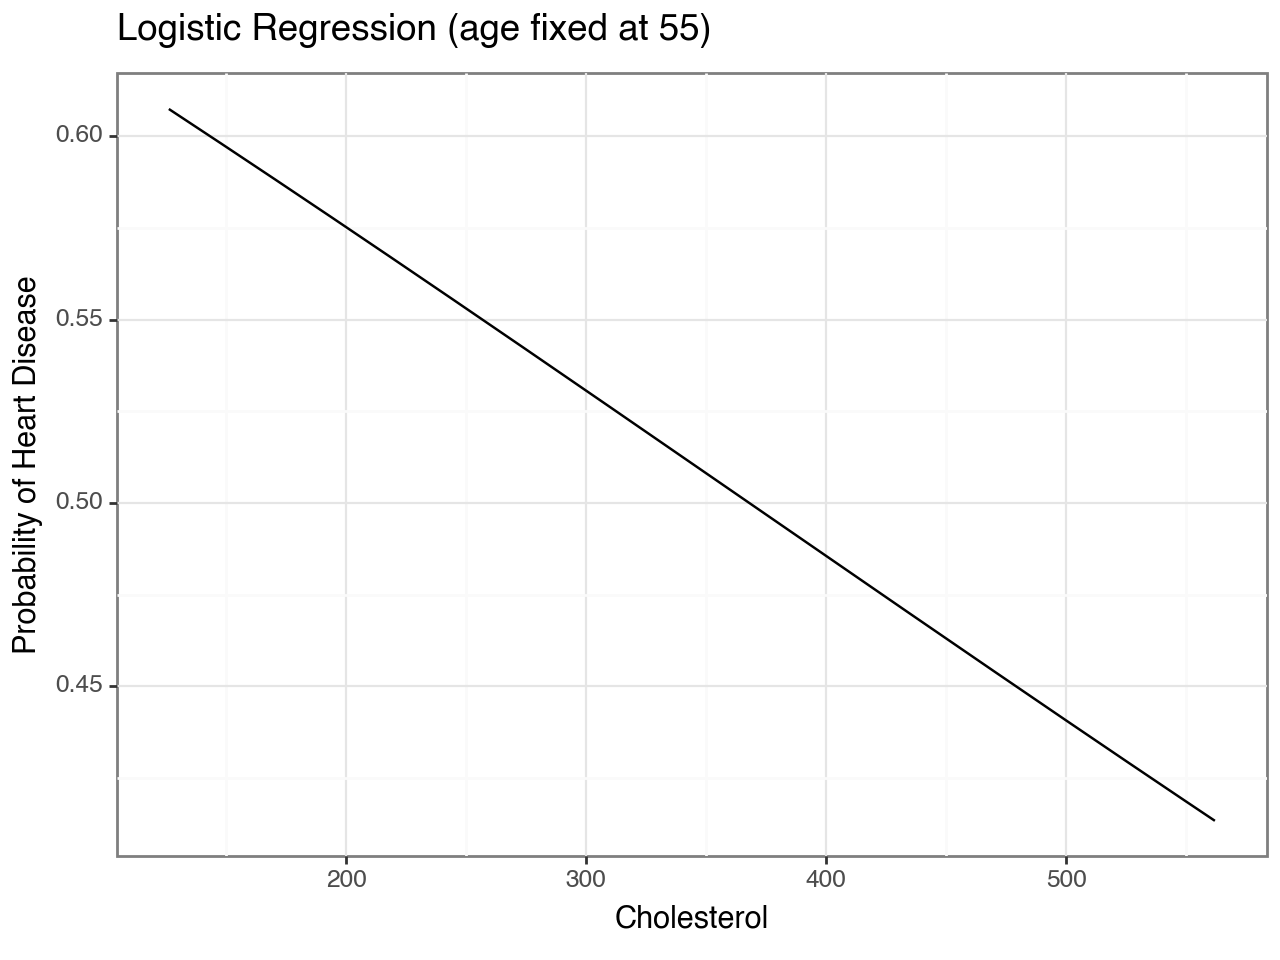

<Figure Size: (640 x 480)>

In [5]:
import pandas as pd
from plotnine import *

# Create a line graph
(
    ggplot(fixed_age_data, aes(x='chol', y='probs')) +
    geom_line() +
    # Add labels and title
    ggtitle('Logistic Regression (age fixed at 55)') +
    xlab('Cholesterol') +
    ylab('Probability of Heart Disease') + 
    theme_bw()
)


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDRPipeline = Pipeline(
  [("preprocessing", ct),
  ("LDR", LinearDiscriminantAnalysis())]
)

LDR_pipeline_fitted = LDRPipeline.fit(X,y)
predicted_probabilities = LDR_pipeline_fitted.predict_proba(fixed_age_data[["age", "chol"]])[:, 1]
fixed_age_data["probs_LDR"] = predicted_probabilities
fixed_age_data

,age,chol,probs,probs_LDR
0,55,126,0.607486,0.606714
1,55,128,0.606624,0.605860
2,55,130,0.605763,0.605005
3,55,132,0.604900,0.604149
4,55,134,0.604037,0.603293
...,...,...,...,...
214,55,554,0.416846,0.417643
215,55,556,0.415969,0.416773
216,55,558,0.415092,0.415903
217,55,560,0.414216,0.415034


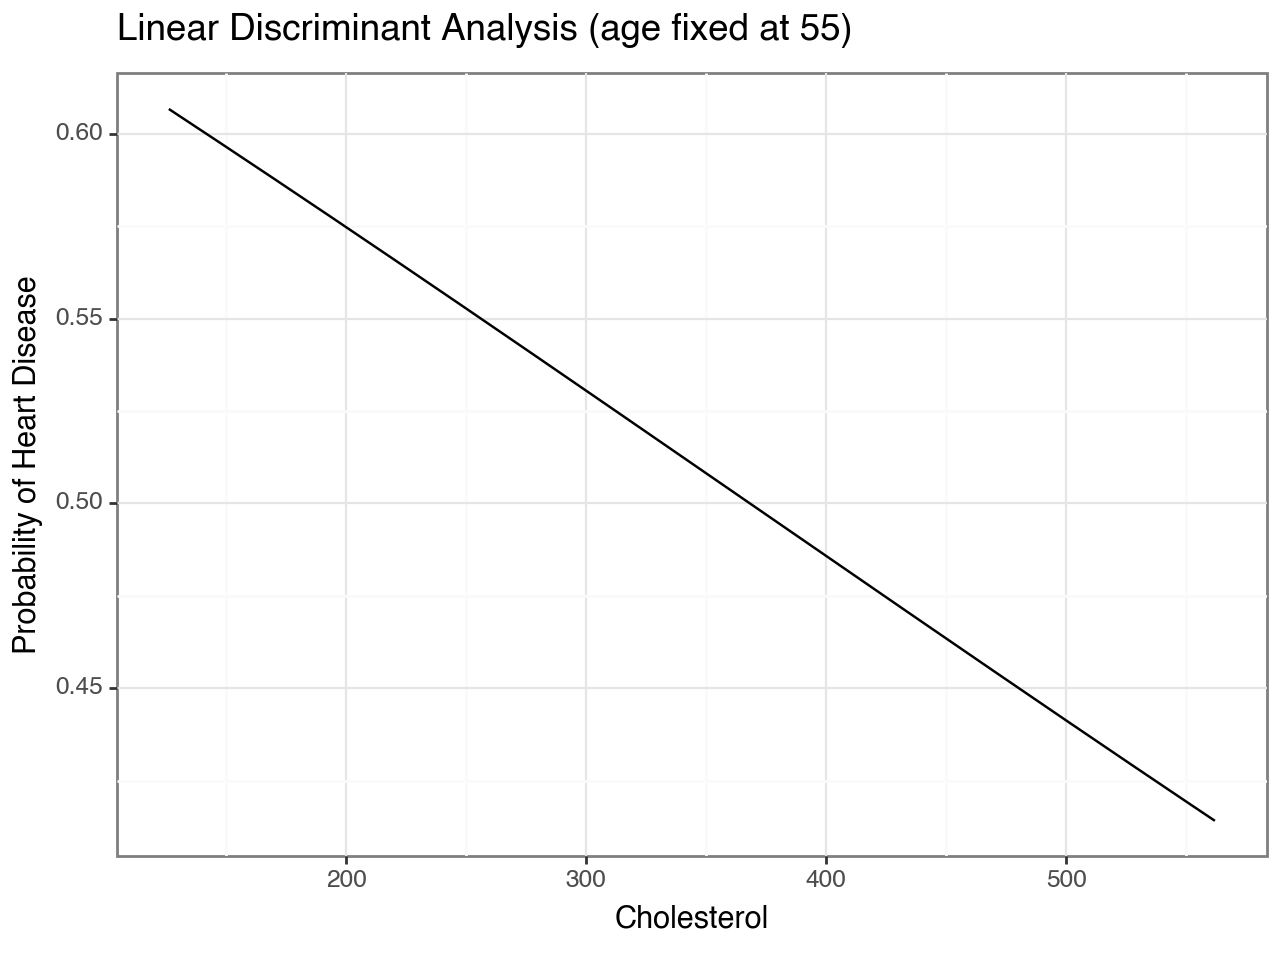

<Figure Size: (640 x 480)>

In [7]:
(
    ggplot(fixed_age_data, aes(x='chol', y='probs_LDR')) +
    geom_line() +
    # Add labels and title
    ggtitle('Linear Discriminant Analysis (age fixed at 55)') +
    xlab('Cholesterol') +
    ylab('Probability of Heart Disease') + 
    theme_bw()
)

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

SVCPipeline = Pipeline(
  [("preprocessing", ct),
  ("SVC", SVC())]
)

# Find optimal n_neighbors based on roc_auc scoring
C = {'SVC__C': np.arange(1, 15)}

gscv = GridSearchCV(SVCPipeline, C, cv = 5, scoring='roc_auc')
gscv_fitted = gscv.fit(X, y)
pd.DataFrame(data = {"C": np.arange(1, 15), "scores": gscv_fitted.cv_results_['mean_test_score']})

,C,scores
0,1,0.610656
1,2,0.599062
2,3,0.597300
3,4,0.588122
4,5,0.573117
5,6,0.569111
6,7,0.561353
7,8,0.552117
8,9,0.546775
9,10,0.539955


In [9]:
SVCPipeline = Pipeline(
  [("preprocessing", ct),
  ("SVC", SVC(C = 1, probability=True))]
)

SVC_pipeline_fitted = SVCPipeline.fit(X,y)
SVC_pipeline_fitted.predict(fixed_age_data[["age", "chol"]])
predicted_probabilities = SVC_pipeline_fitted.predict_proba(fixed_age_data[["age", "chol"]])[:, 1]
fixed_age_data["probs_SVC"] = predicted_probabilities
fixed_age_data

,age,chol,probs,probs_LDR,probs_SVC
0,55,126,0.607486,0.606714,0.646857
1,55,128,0.606624,0.605860,0.646752
2,55,130,0.605763,0.605005,0.646677
3,55,132,0.604900,0.604149,0.646637
4,55,134,0.604037,0.603293,0.646635
...,...,...,...,...,...
214,55,554,0.416846,0.417643,0.631582
215,55,556,0.415969,0.416773,0.631825
216,55,558,0.415092,0.415903,0.632032
217,55,560,0.414216,0.415034,0.632205


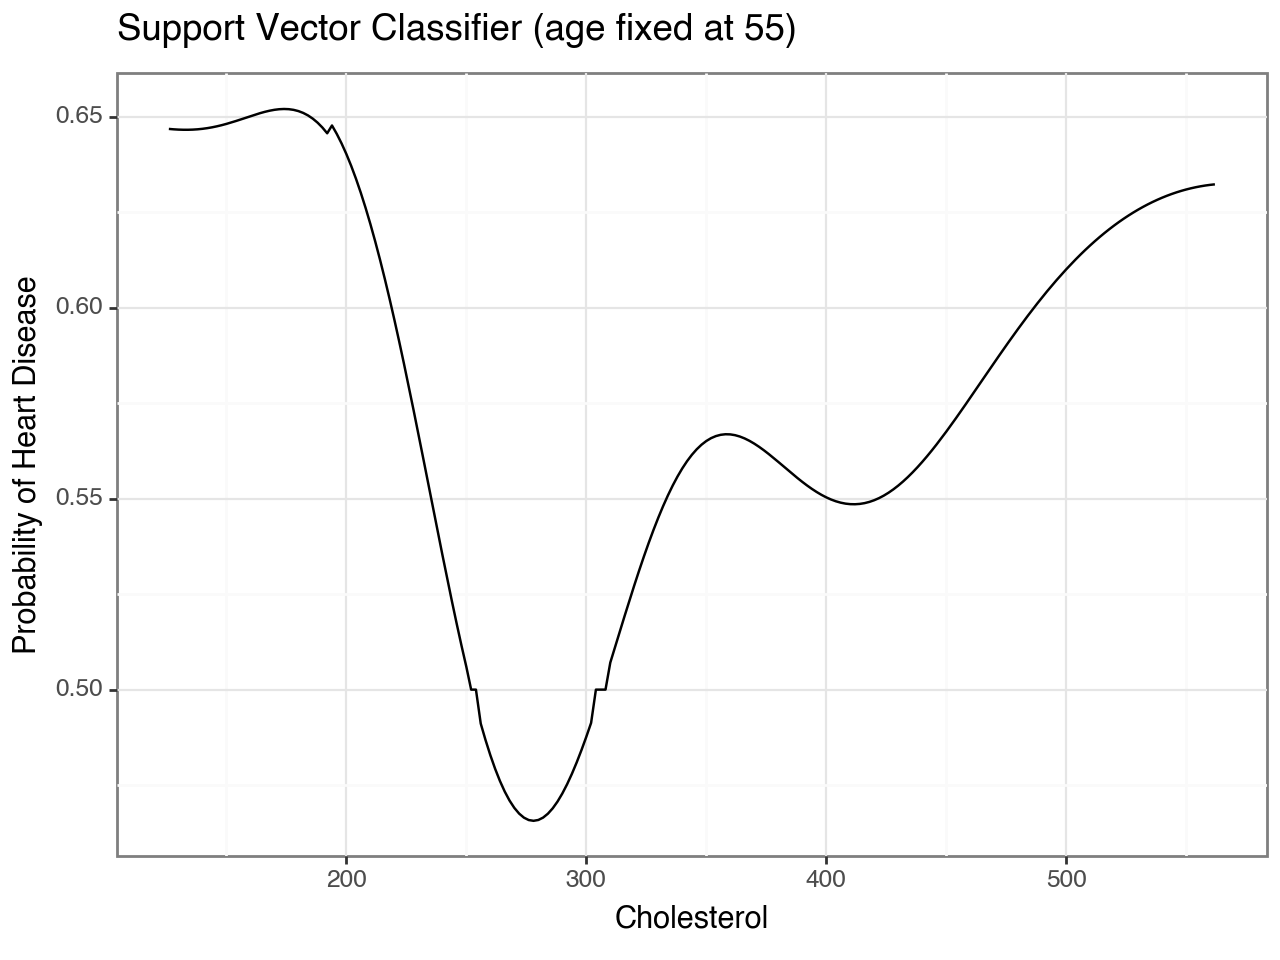

<Figure Size: (640 x 480)>

In [10]:
(
    ggplot(fixed_age_data, aes(x='chol', y='probs_SVC')) +
    geom_line() +
    # Add labels and title
    ggtitle('Support Vector Classifier (age fixed at 55)') +
    xlab('Cholesterol') +
    ylab('Probability of Heart Disease') + 
    theme_bw()
)

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [38]:
data["probs_SVC"] = SVC_pipeline_fitted.predict_proba(data[["age", "chol"]])[:, 1]
data["probs_LDR"] = LDR_pipeline_fitted.predict_proba(data[["age", "chol"]])[:, 1]
data["probs_Log"] = log_pipeline_fitted.predict_proba(data[["age", "chol"]])[:, 1]
data.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis,probs_SVC,probs_LDR,probs_Log
0,Magnolia Cassin,60,1,1,117,230,1,160,0,0.500000,0.503652,0.504976
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,1,0.486191,0.464340,0.465325
2,Miles Wolf,62,0,3,130,263,1,97,0,0.397008,0.465663,0.467219
3,Mikaila Block,43,1,1,115,303,1,181,1,0.650862,0.662720,0.660883
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,1,0.463427,0.402853,0.404918


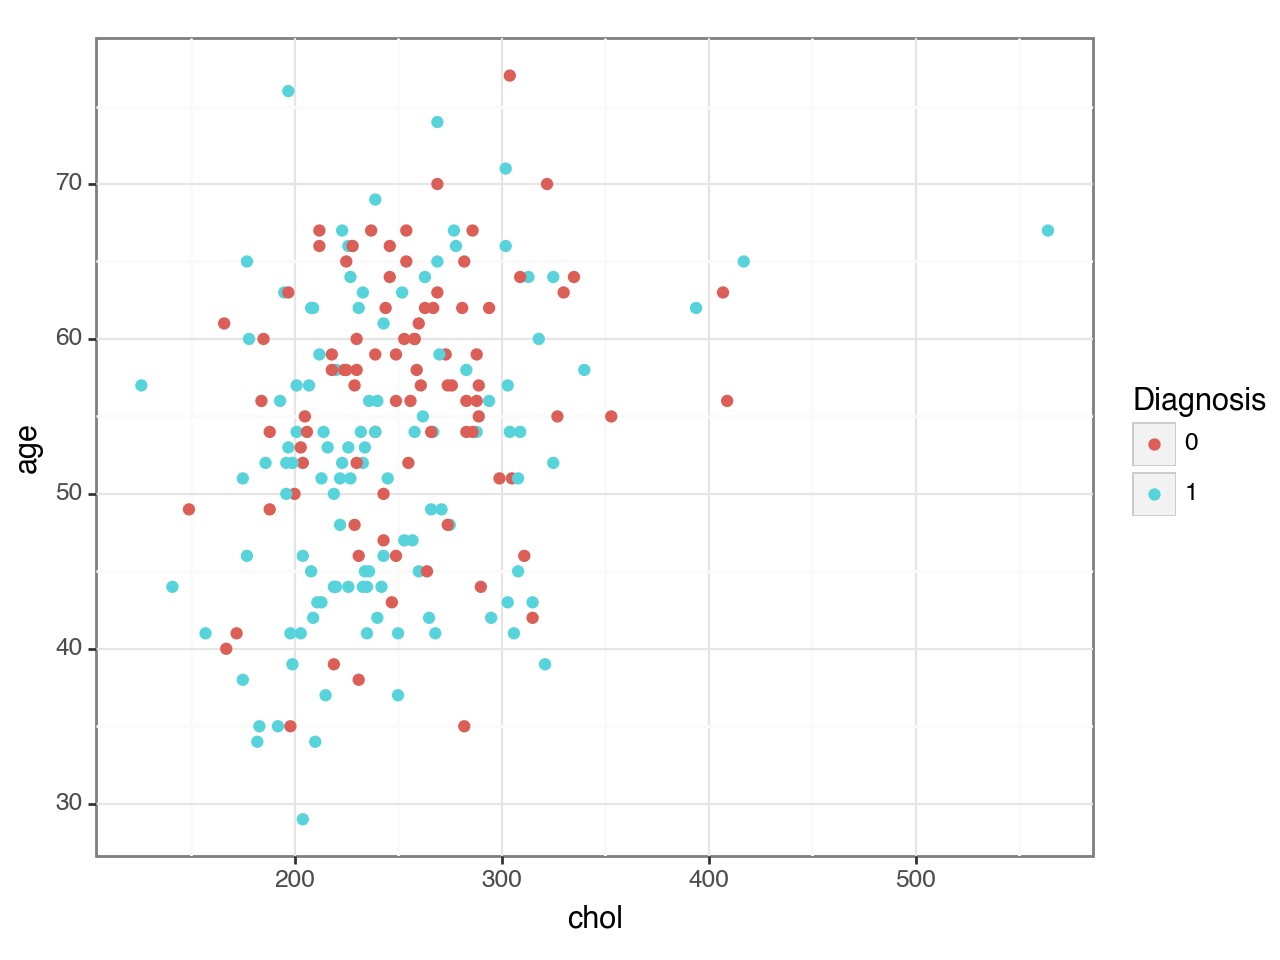

In [23]:
# not restricted to age 55
scatter = (
    ggplot(data, aes(x='chol', y='age', color='diagnosis')) +
    geom_point(size=1.5) +
    labs(title='', x='chol', y='age', color='Diagnosis') +
    theme_bw()
)

test = (
    ggplot(fixed_age_data, aes(x='chol', y='probs_SVC')) +
    geom_line() +
    # Add labels and title
    ggtitle('Support Vector Classifier (age fixed at 55)') +
    xlab('Cholesterol') +
    ylab('Probability of Heart Disease') + 
    theme_bw()
)

print(scatter)